# Figures 8 & 8-1

Neurophysiological differentiation vs. stimulus properties

In [1]:
from pathlib import Path

import matplotlib
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import analysis
from analysis import UNSCRAMBLED_SCRAMBLED

In [2]:
matplotlib.rcParams.update({'font.size': 16})

In [3]:
OUTPUT_DIR = Path("figures")

## Set up R

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(broom)

## Load data

In [6]:
data = (
    pd.read_parquet("results/main.parquet")
    .merge(
        pd.read_parquet("results/stimulus_properties.parquet"),
        on='stimulus'
    )
)

In [7]:
# Only L2/3 of AL & AM
data = data.loc[
    (data["layer"] == "L2/3") &
    data["area"].isin(["AL", "AM"])
]

In [8]:
response = "log(normalized differentiation)"

## Plotting function

In [9]:
def plot_stimulus_property(data, x, y, fig=None, ax=None):
    # Average by stimulus
    data = data.groupby("stimulus").mean().reset_index()
    
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    ax = sb.scatterplot(
        data=data,
        x=x,
        y=y,
        edgecolor=None,
        color="#555",
        marker="o",
        s=85,
        ax=ax,
    )
    
    if x == "mean luminance":
        ax.set_xlim(0, 255)
        ax.set_xticks([0, 64, 128, 192, 256])
    
    ax.set_xlabel("\n" + x.replace("_", " "))
    ax.set_ylabel("neurophysiological differentiation\n")

    # Add annotations
    annotations = [
        ax.text(
            row[x],
            row[y],
            row["stimulus"],
            size="small",
        )
        for idx, row in data.iterrows()
    ]

    return fig, ax

## Figure 8

In [10]:
x = "log(stimulus differentiation)"

In [11]:
y = "log(normalized differentiation)"

PosixPath('figures/fig_8/nd_vs_stimulus_differentiation.svg')

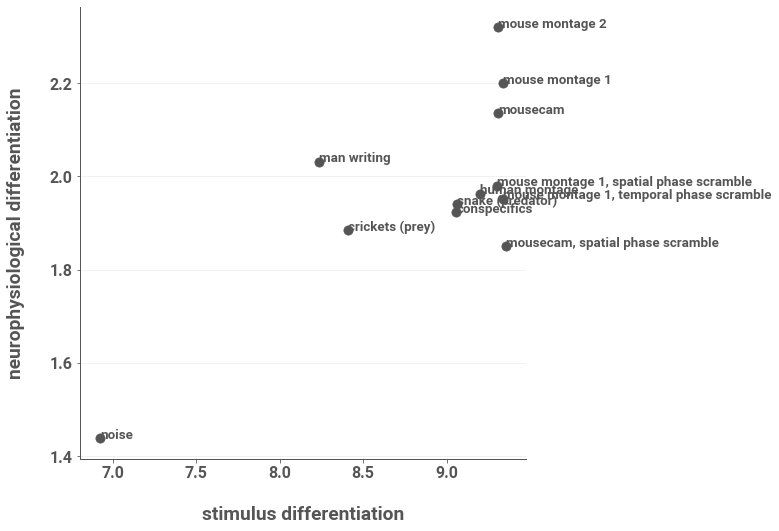

In [12]:
fig, ax = plot_stimulus_property(data, x, y)
ax.set_xlabel("\nstimulus differentiation")
analysis.savefig(fig, OUTPUT_DIR / "fig_8/nd_vs_stimulus_differentiation")

### Correlation

In [13]:
df = data.groupby("stimulus").mean().loc[:, [x, y]]
df

,log(stimulus differentiation),log(normalized differentiation)
stimulus,,
conspecifics,9.058418,1.923011
crickets (prey),8.410413,1.884264
human montage,9.203046,1.963054
man writing,8.232706,2.031114
mouse montage 1,9.340178,2.199659
"mouse montage 1, spatial phase scramble",9.305122,1.979156
"mouse montage 1, temporal phase scramble",9.341091,1.952077
mouse montage 2,9.309863,2.319619
mousecam,9.309972,2.135238


In [14]:
%%R -i df -i x -i response

x = df[[x]]
y = df[[response]]

print(cor.test(x, y, method="pearson", alternative="greater"))


	Pearson's product-moment correlation

data:  x and y
t = 3.5419, df = 10, p-value = 0.00267
alternative hypothesis: true correlation is greater than 0
95 percent confidence interval:
 0.3931238 1.0000000
sample estimates:
      cor 
0.7459556 



### Noise stimulus has high influence

In [15]:
formula = f"`{response}` ~ `{x}`"
formula

'`log(normalized differentiation)` ~ `log(stimulus differentiation)`'

In [16]:
%%R -i data -i formula -o cooks_d

model = lm(formula, data=df)
cooks_d = cooks.distance(model)
cooks_d = tidy(cooks_d)

/home/wmayner/miniconda3/envs/openscope-differentiation-test3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2085: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  values, tz_parsed = conversion.datetime_to_datetime64(data)
/home/wmayner/miniconda3/envs/openscope-differentiation-test3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2201: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  elif not timezones.tz_compare(tz, inferred_tz):
/home/wmayner/miniconda3/envs/openscope-differentiation-test3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2282: PytzUsageWarning: The zone attribute is specific to pytz's i

In [17]:
cooks_d = (
    cooks_d
    .rename(columns=dict(x="Cook's d"))
    .sort_values("Cook's d", ascending=False)
)
cooks_d

,names,Cook's d
11,noise,2.317680
4,man writing,0.224292
8,mouse montage 2,0.212324
10,"mousecam, spatial phase scramble",0.158827
5,mouse montage 1,0.059372
7,"mouse montage 1, temporal phase scramble",0.041309
9,mousecam,0.018565
6,"mouse montage 1, spatial phase scramble",0.018514
1,conspecifics,0.014396
3,human montage,0.013451


### Correlation without noise stimulus

In [18]:
subset = df.loc[df.index != "noise"]

In [19]:
%%R -i subset -i x -i response

x = subset[[x]]
y = subset[[response]]

print(cor.test(x, y, method="pearson", alternative="greater"))


	Pearson's product-moment correlation

data:  x and y
t = 0.80131, df = 9, p-value = 0.2218
alternative hypothesis: true correlation is greater than 0
95 percent confidence interval:
 -0.3072614  1.0000000
sample estimates:
      cor 
0.2580565 



### Correlation among controlled stimuli

In [20]:
subset = df.loc[df.index.isin(UNSCRAMBLED_SCRAMBLED)]

In [21]:
%%R -i subset -i x -i response

x = subset[[x]]
y = subset[[response]]

print(cor.test(x, y, method="pearson", alternative="two.sided"))


	Pearson's product-moment correlation

data:  x and y
t = -0.70814, df = 3, p-value = 0.5299
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9451384  0.7563673
sample estimates:
       cor 
-0.3784362 



## Figure 8-1

PosixPath('figures/fig_8-1/nd_vs_stimulus_properties.svg')

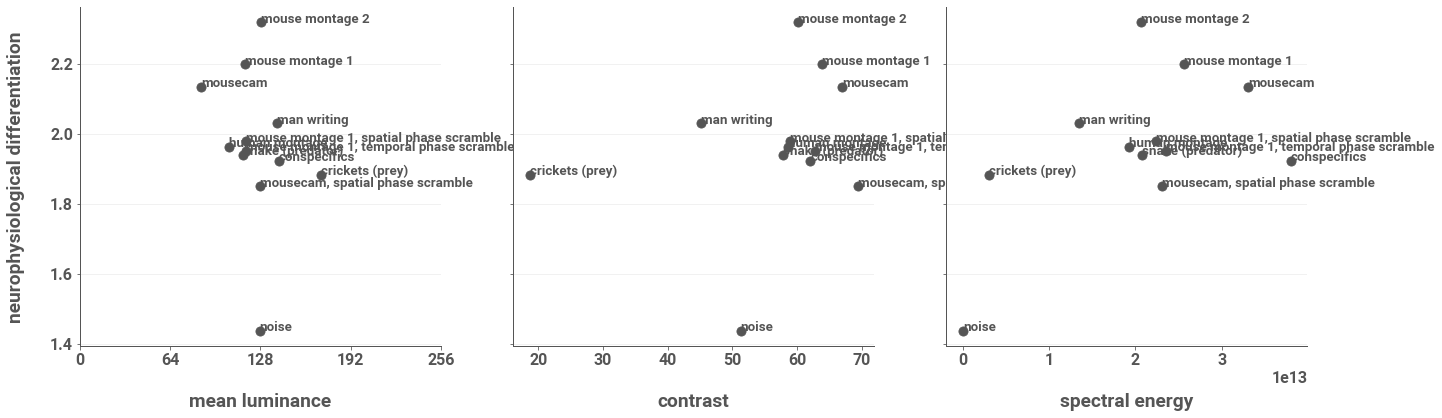

In [22]:
fig, grid = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(22, 6))

x = "mean luminance"
fig, ax = plot_stimulus_property(data, x, y, fig=fig, ax=grid[0])

x = "contrast"
fig, ax = plot_stimulus_property(data, x, y, fig=fig, ax=grid[1])
ax.set_ylabel("")

x = "spectral energy"
fig, ax = plot_stimulus_property(data, x, y, fig=fig, ax=grid[2])
ax.set_ylabel("")

analysis.savefig(fig, OUTPUT_DIR / "fig_8-1/nd_vs_stimulus_properties")